<a href="https://colab.research.google.com/github/ayberkozcan/pytorch-computer-vision/blob/main/Object_Classification_with_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Classification with CIFAR-10

In this notebook, we are going to load the CIFAR-10 dataset, use some pretrained models, and compare their performance.

## Importing Libraries

In [3]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Downloading CIFAR-10 Dataset

In [5]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    transform=ToTensor(),
    target_transform=None,
    download=True
)
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True
)

100%|██████████| 170M/170M [00:08<00:00, 20.8MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Exploring our Dataset

In [6]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

There are 50.000 training samples and 10.000 testing samples.

In [7]:
# Let's see classes
class_names = train_data.classes

print(f"Class shape: {len(class_names)}")
print(f"Classes\n{class_names}")

Class shape: 10
Classes
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Image shape: torch.Size([3, 32, 32])


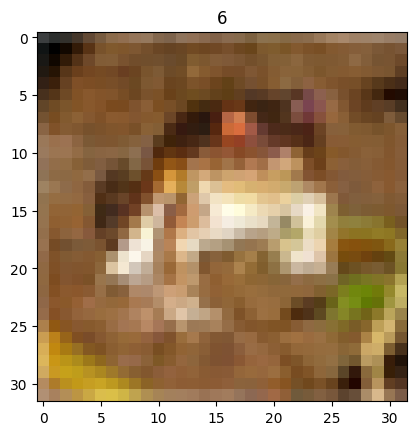

In [8]:
# Let's see a sample and learn its shape
image, label = train_data[0]

print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.show()

We changed the shape from (3, 32, 32) to (32, 32, 3), making it compatible with imshow.

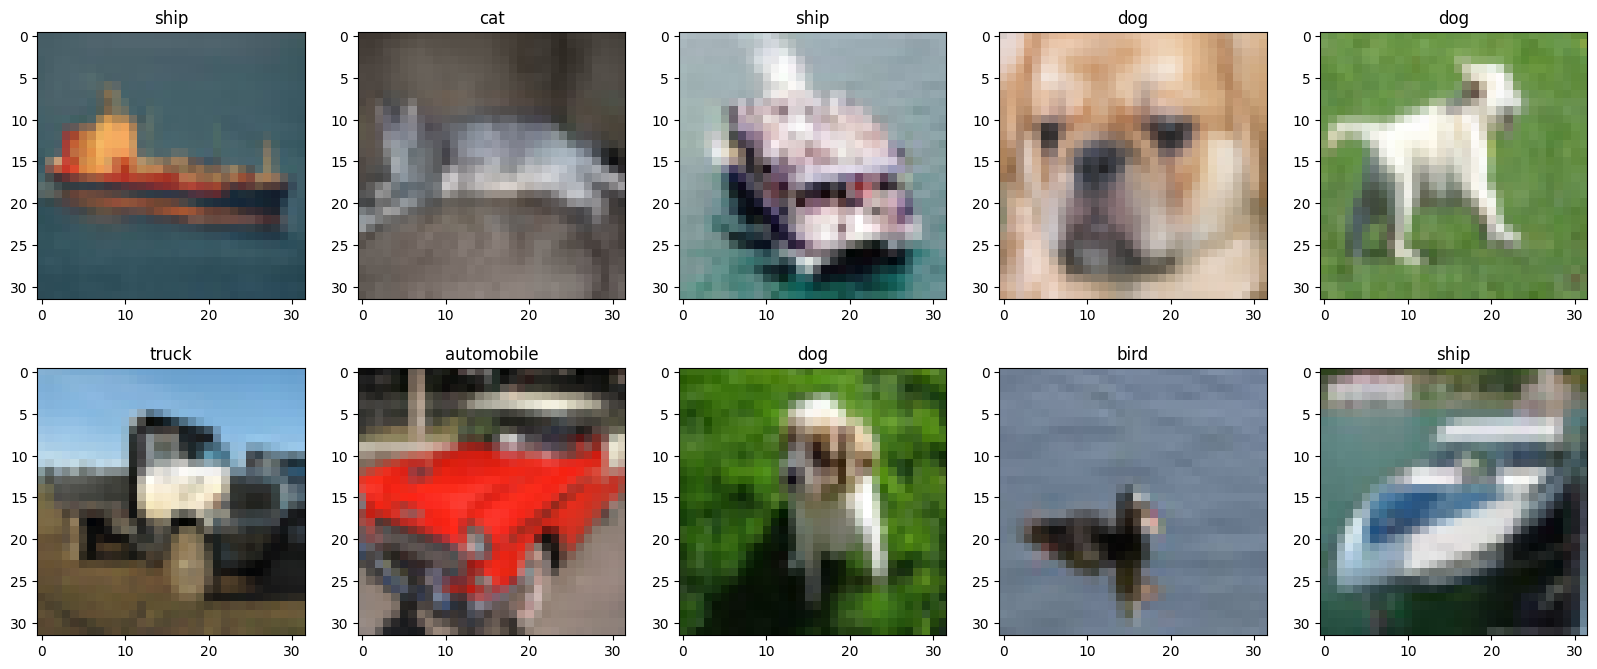

In [9]:
# Let's plot more images to explore our data
fig = plt.figure(figsize=(20, 8))
rows, cols = 2, 5
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0))
  plt.title(class_names[label])

plt.show()

## Data Augmentation

We might augment our data a little to improve model performance when classifying more challenging images.

In [10]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

In [11]:
train_data_transformed = datasets.CIFAR10(
    root="data",
    train=True,
    transform=transform,
    target_transform=None,
    download=True
)
test_data_transformed = datasets.CIFAR10(
    root="data",
    train=False,
    transform=transform,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


Image shape: torch.Size([3, 32, 32])


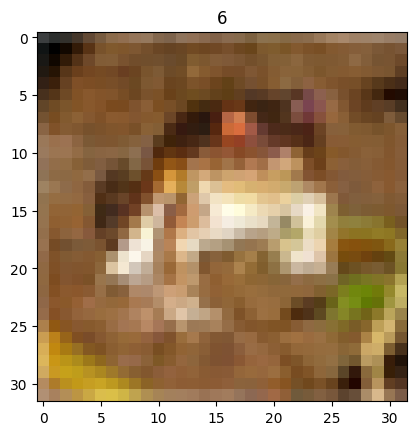

In [12]:
# Let's see a sample and learn its shape
image, label = train_data_transformed[0]

print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.show()

## Preparing Data with DataLoader

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataloader = DataLoader(
    train_data_transformed,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data_transformed,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

In [14]:
print(f"Length of train dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")

Length of train dataloader: 1563
Length of test dataloader: 313


## Transfer Learning

We're going to be using pretrained Efficientnet model.

In [15]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 121MB/s]


We can use summary() to get information about our pretrained model.

In [16]:
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

We can to freeze base layers.

In [17]:
for param in model.features.parameters():
  param.requires_grad = False

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

in_shape = model.classifier[1].in_features
output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=in_shape,
        out_features=output_shape,
        bias=True
    )
).to(device)

Let's see what's changed

In [19]:
summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train model

DataLoaders and pretrained model are ready for train.

In [20]:
loss_fn = nn.CrossEntropyLoss() # multi-class classification
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [21]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from tqdm.auto import tqdm

from timeit import default_timer as timer
train_time_start = timer()

epochs = 10

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    model.train()

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(
        y_true=y,
        y_pred=y_pred.argmax(dim=1)
    )

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss

      accuracy = accuracy_fn(
          y_true=y, y_pred=test_pred.argmax(dim=1)
      )
      test_acc += accuracy

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%, Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

  results["train_loss"].append(train_loss.item()) if isinstance(train_loss, torch.Tensor) else train_loss
  results["train_acc"].append(train_acc.item()) if isinstance(train_acc, torch.Tensor) else train_acc
  results["test_loss"].append(test_loss.item()) if isinstance(test_loss, torch.Tensor) else test_loss
  results["test_acc"].append(test_acc.item()) if isinstance(test_acc, torch.Tensor) else test_acc

train_time_end = timer()
total_time = train_time_end - train_time_start

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.94576 | Train Accuracy: 31.97%, Test Loss: 1.86088 | Test Accuracy: 35.58%

Epoch: 1
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.91244 | Train Accuracy: 33.71%, Test Loss: 1.88260 | Test Accuracy: 34.95%

Epoch: 2
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.91454 | Train Accuracy: 33.72%, Test Loss: 1.87802 | Test Accuracy: 35.42%

Epoch: 3
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 1.91626 | Train Accuracy: 33.54%, Test Loss: 1.84903 | Test Accuracy: 35.88%

Epoch: 4
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samp

Our model doesn't seem to have done well. Let's try another model.

In [23]:
weights_2 = torchvision.models.ResNet18_Weights.DEFAULT
model_2 = torchvision.models.resnet18(weights=weights_2).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


In [24]:
for param in model_2.fc.parameters():
  param.requires_grad = False

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

in_shape = model_2.fc.in_features
output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=in_shape,
        out_features=output_shape,
        bias=True
    )
).to(device)

In [42]:
loss_fn = nn.CrossEntropyLoss() # multi-class classification
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.01)

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from tqdm.auto import tqdm

from timeit import default_timer as timer
train_time_start = timer()

epochs = 10

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    model_2.train()

    y_pred = model_2(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(
        y_true=y,
        y_pred=y_pred.argmax(dim=1)
    )

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  test_loss, test_acc = 0, 0

  model_2.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model_2(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss

      accuracy = accuracy_fn(
          y_true=y, y_pred=test_pred.argmax(dim=1)
      )
      test_acc += accuracy

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%, Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

train_time_end = timer()
total_time = train_time_end - train_time_start

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 0.74004 | Train Accuracy: 74.82%, Test Loss: 0.91996 | Test Accuracy: 69.42%

Epoch: 1
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 0.68778 | Train Accuracy: 76.49%, Test Loss: 0.85100 | Test Accuracy: 70.73%

Epoch: 2
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 0.60378 | Train Accuracy: 79.15%, Test Loss: 0.68325 | Test Accuracy: 77.07%

Epoch: 3
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train Loss: 0.54695 | Train Accuracy: 81.49%, Test Loss: 0.73393 | Test Accuracy: 75.85%

Epoch: 4
--------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samp

ResNet18 model has done pretty well. Let's visualize loss and accuracy for further information.

## Evaluation

### Loss and Accuracy Plots

In [45]:
loss = results["train_loss"]
test_loss = results["test_loss"]

accuracy = results["train_acc"]
test_accuracy = results["test_acc"]

epochs = range(len(results["train_loss"]))

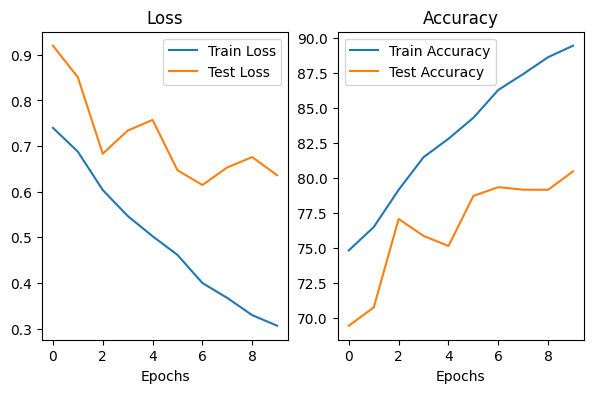

In [46]:
plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, test_loss, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="Train Accuracy")
plt.plot(epochs, test_accuracy, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

It looks like the ResNet18 model performed well with the learning rate 0.01.

Note: I trained the model with learning rate 0.001 and the overfitting was worse, so i changed it by 0.01.

### Confusion Matrix

In [47]:
from tqdm.auto import tqdm

y_preds = []

model_2.to(device)

model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = model_2(X)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)

Making Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [48]:
try:
  import torchmetrics, mlxtend
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print("Installation done!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.6 MB/s eta 0:00:00
Installation done!


In [49]:
print(f"torchmetrics version: {torchmetrics.__version__}")
print(f"mlxtend version: {mlxtend.__version__}")

torchmetrics version: 1.6.1
mlxtend version: 0.23.4


In [50]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [57]:
a = torch.tensor(test_data.targets)

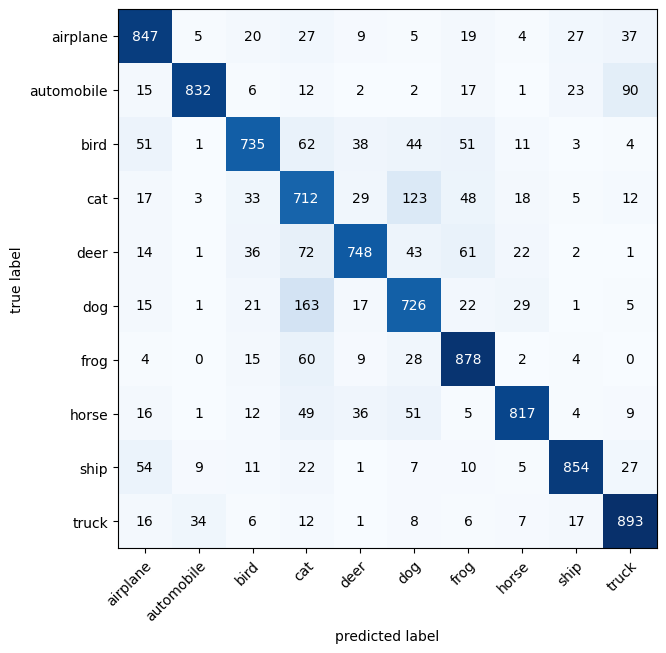

In [61]:
confmat = ConfusionMatrix(
    num_classes=len(class_names),
    task="multiclass"
).to(device)
confmat_tensor = confmat(
    preds=y_pred_tensor,
    target=torch.tensor(test_data.targets).to(device)
)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

## Making Prediction on a Custom Object